In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import openllm

In [59]:
model_name = "./models/phi-1_5"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [60]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [76]:
prompt = "i need to "



inputs = tokenizer(prompt, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

torch.Size([1, 4, 51200])


['\n', '\n\n', 'ids', '\r', 'ive', 'ia', '????', 'ı', '________', 'xt']

In [52]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [77]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(prompt)
print(generated_tokens)

3.4127609729766846 s
i need to 
['\n', '    ', '#', '   ', '1', '.', ' get', ' the', ' number', ' of']


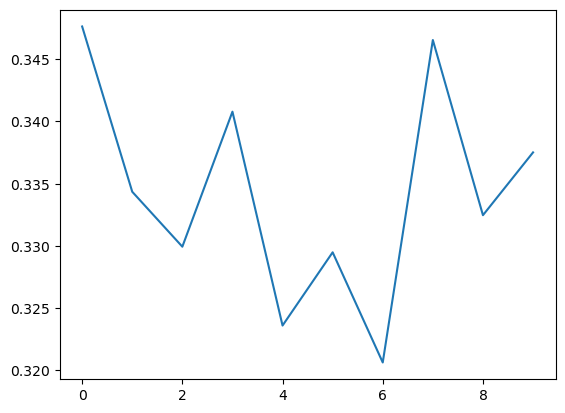

In [68]:
plt.plot(durations_s)
plt.show()

In [42]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [74]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

2.3406457901000977 s
[' be', ' strong', ' and', ' sturdy', '.', ' But', ' if', ' I', ' am', ' a']


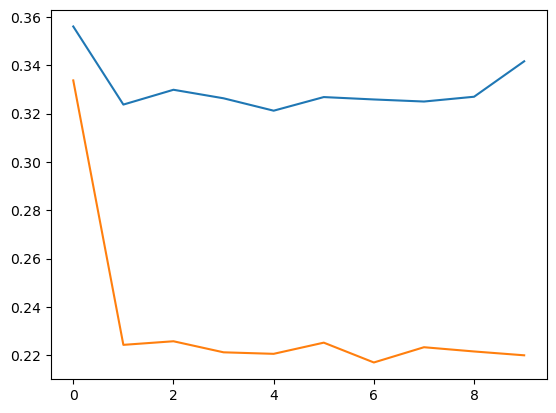

In [71]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()